In [42]:
import string
import re


def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""

  def remove_articles(text):
    return re.sub(r'\b(a|an|the)\b', ' ', text)

  def white_space_fix(text):
    return ' '.join(text.split())

  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

  def lower(text):
    return text.lower()

  return white_space_fix(remove_articles(remove_punc(lower(s))))

def calculate_short_answer_EM(generated_answer, gold_answers, language="en"):
    if isinstance(gold_answers, str):
        gold_answers = [gold_answers]
    if language == "en":
        generated_answer=normalize_answer(generated_answer)
    else:
        pass
    match=0
    for gold_answer in gold_answers:
        gold_answer=normalize_answer(gold_answer)
        if gold_answer in generated_answer:
            match+=1
    return {
        "exact_match": match/len(gold_answers),
        "hit1": match>0
    }

# sample training data
import evaluate
from collections import defaultdict
#  parse gpt4 response
import bs4
rouge=evaluate.load("../evaluate_utils/rouge/")

In [43]:
from typing import Tuple, List
import bs4

def split_tree(soup: bs4.BeautifulSoup) -> List[Tuple[bs4.element.Tag, List[str]]]:
    word_count = len(soup.get_text().split())
    if word_count > 500:
        possible_trees = [(soup, [])]
        target_trees = []
        #  split the entire dom tee into subtrees, until the length of the subtree is less than 500 words
        #  find all possible trees
        while True:
            if len(possible_trees) == 0:
                break
            tree = possible_trees.pop(0)
            tag_children = defaultdict(int)
            bare_word_count = 0
            #  count child tags
            for child in tree[0].contents:
                if isinstance(child, bs4.element.Tag):
                    tag_children[child.name] += 1
            _tag_children = {k: 0 for k in tag_children.keys()}
            for child in tree[0].contents:
                if isinstance(child, bs4.element.Tag):
                    #  change child tag with duplicate names
                    if tag_children[child.name] > 1:
                        new_name = f"{child.name}{_tag_children[child.name]}"
                        new_tree = (child, tree[1] + [new_name])
                        _tag_children[child.name] += 1
                        child.name = new_name
                    else:
                        new_tree = (child, tree[1] + [child.name])
                    word_count = len(child.get_text().split())
                    if word_count > 500:
                        possible_trees.append(new_tree)
                    else:
                        target_trees.append(new_tree)
                else:
                    bare_word_count += len(str(child).split())

            #  add node with more than 500 words
            if bare_word_count > 500:
                target_trees.append(tree)
            #  add leaf node
            if len(tag_children) == 0:
                target_trees.append(tree)
    else:
        soup_children = [c for c in soup.contents if isinstance(c, bs4.element.Tag)]
        if len(soup_children) == 1:
            target_trees = [(soup_children[0], [soup_children[0].name])]
        else:
            # add an html tag to wrap all children
            new_soup = bs4.BeautifulSoup("", 'html.parser')
            new_tag = new_soup.new_tag("html")
            new_soup.append(new_tag)
            for child in soup_children:
                new_tag.append(child)
            target_trees = [(new_tag, ["html"])]
    return target_trees

In [44]:
#  init tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM

ckpt_path="../../../huggingface/Baichuan2-7B-Chat/"
tokenizer = AutoTokenizer.from_pretrained(ckpt_path,trust_remote_code=True)


In [45]:
import json
import numpy as np

split = "test"
rewrite_method = "slimplmqr"
dataset = "asqa"
version="v0715"
search_engine="bing"
context_window = "16k"

ref_file = f"../html_data/{dataset}/treegen/{version}/{search_engine}html-{rewrite_method}-{version}-{dataset}-{split}-{context_window}.jsonl"

ref_lines = [json.loads(line) for line in open(ref_file, "r")]

if "answers" in ref_lines[0]:
    answers = [ref_line['answers'] for ref_line in ref_lines]
elif "short_answers" in ref_lines[0]:
    answers = [ref_line['short_answers'] for ref_line in ref_lines]
elif "answer" in ref_lines[0]:
    answers = [ref_line['answer'] for ref_line in ref_lines]
else:
    raise NotImplementedError("answers not found in ref_lines")


In [46]:
idx=83
print(ref_lines[idx].keys())
#  dict_keys(['qa_pairs', 'wikipages', 'annotations', 'id', 'question', 'answer', 'short_answers', 'long_answers', 'html', 'paths', 'path_token_ids', 'node_tree', 'html_trim'])

#  find answer matching paths
question = ref_lines[idx]["question"]
html = ref_lines[idx]["html"]
html_trim = ref_lines[idx]["html_trim"]
answer = answers[idx]
node_tree=ref_lines[idx]["node_tree"]
paths=ref_lines[idx]["paths"]  


dict_keys(['qa_pairs', 'wikipages', 'annotations', 'id', 'question', 'answer', 'short_answers', 'long_answers', 'html', 'paths', 'path_token_ids', 'node_tree', 'path_divisible', 'html_trim'])


In [47]:
from langchain_core.documents.base import Document
import pathlib
import os
from tqdm import tqdm
from typing import AsyncIterator, Iterator, List, Dict, Optional, Any, cast
from langchain_text_splitters import HTMLSectionSplitter

def clean_xml(html):
    # remove tags starts with <?xml
    html = re.sub(r"<\?xml.*?>", "", html)
    # remove tags starts with <!DOCTYPE
    html = re.sub(r"<!DOCTYPE.*?>", "", html)
    return html

headers_to_split_on = [
    ("h1", "Header 1"),
    ("h2", "Header 2"),
    ("h3", "Header 3"),
    ("h4", "Header 4"),
    ("body", "Body"),
]


class HTMLSplitter(HTMLSectionSplitter):
    def split_html_by_headers(
            self, html_doc: str
    ) -> List[Dict[str, Optional[str]]]:
        try:
            from bs4 import BeautifulSoup, PageElement  # type: ignore[import-untyped]
        except ImportError as e:
            raise ImportError(
                "Unable to import BeautifulSoup/PageElement, \
                    please install with `pip install \
                    bs4`."
            ) from e

        soup = BeautifulSoup(html_doc, "html.parser")
        headers = list(self.headers_to_split_on.keys())
        sections = []

        headers = soup.find_all(["body"] + headers)

        for i, header in enumerate(headers):
            header_element: PageElement = header
            if i == 0:
                current_header = "#TITLE#"
                current_header_tag = "h1"
                section_content: List = []
            else:
                current_header = header_element.text.strip()
                current_header_tag = header_element.name
                section_content = []
            for element in header_element.next_elements:
                if i + 1 < len(headers) and element == headers[i + 1]:
                    break
                if isinstance(element, str):
                    section_content.append(element)
            content = " ".join(section_content).strip()

            if content != "":
                sections.append({
                    "header": current_header,
                    "content": content,
                    "tag_name": current_header_tag,
                })

        return sections

    def split_text_from_file(self, file: Any) -> List[Document]:
        """Split HTML file

        Args:
            file: HTML file
        """
        file_content = file.getvalue()
        file_content = self.convert_possible_tags_to_header(file_content)
        sections = self.split_html_by_headers(file_content)

        return [
            Document(
                cast(str, section["content"]),
                metadata={
                    self.headers_to_split_on[
                        str(section["tag_name"])
                    ]: section["header"]
                },
            )
            for section in sections
        ]

    def convert_possible_tags_to_header(self, html_content: str) -> str:
        if self.xslt_path is None:
            return html_content

        try:
            from lxml import etree
        except ImportError as e:
            raise ImportError(
                "Unable to import lxml, please install with `pip install lxml`."
            ) from e
        # use lxml library to parse html document and return xml ElementTree
        parser = etree.HTMLParser()
        try:
            tree = etree.fromstring(html_content, parser)
        except:
            open("error_html.html", "w").write(html_content)

        # document transformation for "structure-aware" chunking is handled with xsl.
        # this is needed for htmls files that using different font sizes and layouts
        # check to see if self.xslt_path is a relative path or absolute path
        if not os.path.isabs(self.xslt_path):
            xslt_path = pathlib.Path(__file__).parent / self.xslt_path

        xslt_tree = etree.parse("../html4rag/converting_to_header.xslt")
        transform = etree.XSLT(xslt_tree)
        result = transform(tree)
        return str(result)


html_splitter = HTMLSplitter(headers_to_split_on=headers_to_split_on)

In [48]:
from tqdm import tqdm
import numpy as np
import bs4
rerank_model="bgelargeen"
from collections import defaultdict
import multiprocessing

processes=[]
context_windows=["2k", "4k", "8k", "16k", "32k"]
versions=["v0701", "v0715"]
chat_tokenizer="llama"
context_window_recalls=multiprocessing.Manager().list([0.0]*(len(context_windows)*len(versions)))

def calculate_answer_recall(context_window, version):
    reference_format="treegen"
    if reference_format in ["html-trim"]:
        ref_file = f"../html_data/{dataset}/{search_engine}/{reference_format}/{chat_tokenizer}/{search_engine}html-{rewrite_method}-{rerank_model}-{dataset}-{split}-{context_window}.jsonl"
    elif reference_format in ["treegen"]:
        ref_file = f"../html_data/{dataset}/treegen/{version}/{chat_tokenizer}/{search_engine}html-{rewrite_method}-{version}-{dataset}-{split}-{context_window}.jsonl"
    else:
        raise NotImplementedError("reference_format not found")
    print(f"ref_file: {ref_file}")
    ref_lines = [json.loads(line) for line in open(ref_file, "r")]
    
    if "answers" in ref_lines[0]:
        answers = [ref_line['answers'] for ref_line in ref_lines]
    elif "short_answers" in ref_lines[0]:
        answers = [ref_line['short_answers'] for ref_line in ref_lines]
    elif "answer" in ref_lines[0]:
        answers = [ref_line['answer'] for ref_line in ref_lines]
    else:
        raise NotImplementedError("answers not found in ref_lines")
    recall=[]
    for idx in tqdm(range(len(ref_lines)), desc=f"{version}: {context_window}"):
        html=ref_lines[idx]["html"]
        if reference_format in ["html-trim", "treegen"]:
            html_trim=ref_lines[idx]["html_trim"]
        elif reference_format in ["fill-chunk"]:
            html_trim=ref_lines[idx]["fill-chunk"]
        else:
            raise NotImplementedError("reference_format not found")
        answer=answers[idx]
        # token_html = tokenizer.tokenize(html)
        # token_html_trim = tokenizer.tokenize(html_trim)
        # print(f"length of token_html: {len(token_html)}, length of token_html_trim: {len(token_html_trim)}")
        
        #  split the html into subtrees
        soup = bs4.BeautifulSoup(html, 'html.parser')
        
        html_chunk_paths = split_tree(soup)
        matched_paths = []
        
        for path in html_chunk_paths:
            if calculate_short_answer_EM(str(path[0]), answer)["exact_match"] > 0.0:
                matched_paths.append(path)
                
        if len(matched_paths) == 0:
            continue
        else:
            #  visit soup trim through matched paths
            kept_matched_paths = []
            soup_trim = bs4.BeautifulSoup(html_trim, 'html.parser')
            for matched_path in matched_paths:
                path = matched_path[1]
                tag = soup_trim
                for p in path:
                    for child in tag.contents:
                        if isinstance(child, bs4.element.Tag):
                            if child.name == p:
                                tag = child
                                break
                #  check if trace to the end of the path
                if tag.name == path[-1]:
                    kept_matched_paths.append(matched_path)
                    # print(f"matched path: {path}")
            recall.append(len(kept_matched_paths)/len(matched_paths))
    recall_mean=np.mean(recall)
    # print(f"version: {version} context_window: {context_window}, recall: {recall_mean}")
    version_idx=versions.index(version)
    context_window_idx=context_windows.index(context_window)
    context_window_recalls[context_window_idx+version_idx*len(context_windows)]=recall_mean
    
for version in versions:
    for widx in range(len(context_windows)):
        context_window=context_windows[widx]
        p=multiprocessing.Process(target=calculate_answer_recall, args=(context_window, version))
        p.start()
        processes.append(p)
    
for p in processes:
    p.join()

ref_file: ../html_data/asqa/treegen/v0701/llama/binghtml-slimplmqr-v0701-asqa-test-2k.jsonl
ref_file: ../html_data/asqa/treegen/v0701/llama/binghtml-slimplmqr-v0701-asqa-test-4k.jsonl
ref_file: ../html_data/asqa/treegen/v0701/llama/binghtml-slimplmqr-v0701-asqa-test-8k.jsonl
ref_file: ../html_data/asqa/treegen/v0701/llama/binghtml-slimplmqr-v0701-asqa-test-16k.jsonl
ref_file: ../html_data/asqa/treegen/v0701/llama/binghtml-slimplmqr-v0701-asqa-test-32k.jsonl
ref_file: ../html_data/asqa/treegen/v0715/llama/binghtml-slimplmqr-v0715-asqa-test-2k.jsonl
ref_file: ../html_data/asqa/treegen/v0715/llama/binghtml-slimplmqr-v0715-asqa-test-4k.jsonl
ref_file: ../html_data/asqa/treegen/v0715/llama/binghtml-slimplmqr-v0715-asqa-test-8k.jsonl
ref_file: ../html_data/asqa/treegen/v0715/llama/binghtml-slimplmqr-v0715-asqa-test-16k.jsonl
ref_file: ../html_data/asqa/treegen/v0715/llama/binghtml-slimplmqr-v0715-asqa-test-32k.jsonl


v0701: 8k:  12%|█▏        | 46/400 [00:32<02:58,  1.99it/s]]/data_train/search/InternData/jiejuntan/anaconda3/envs/py39/lib/python3.9/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)
v0715: 8k:  48%|████▊     | 191/400 [02:02<01:54,  1.82it/s]]/data_train/search/InternData/jiejuntan/anaconda3/envs/py39/lib/python3.9/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parse

In [49]:
import multiprocessing
dataset="asqa"
context_windows=["2k", "4k", "8k", "16k", "32k"]
reference_formats = ["chunk-rerank", "tree-rerank"]
html_trim_recalls=multiprocessing.Manager().list([0.0]*len(context_windows)*len(reference_formats))
def calculate_html_trim_recall(context_window, reference_format): 
    recalls=[]
    
    ref_file = f"../html_data/{dataset}/{reference_format}/{chat_tokenizer}/{search_engine}html-{rewrite_method}-{rerank_model}-{dataset}-{split}-{context_window}.jsonl"
    print(f"ref_file: {ref_file}")
    ref_lines = [json.loads(line) for line in open(ref_file, "r")]
    
    if "answers" in ref_lines[0]:
        answers = [ref_line['answers'] for ref_line in ref_lines]
    elif "short_answers" in ref_lines[0]:
        answers = [ref_line['short_answers'] for ref_line in ref_lines]
    elif "answer" in ref_lines[0]:
        answers = [ref_line['answer'] for ref_line in ref_lines]
    else:
        raise NotImplementedError("answers not found in ref_lines")
    for idx in tqdm(range(len(ref_lines)), desc=f"html-trim {context_window}"):
        # print(ref_lines[idx].keys())
        page_contents = ref_lines[idx]["page_contents"]
        metadatas = ref_lines[idx]["metadatas"]
        
        matched_page_contents = []
        for pidx in range(len(page_contents)):
            if calculate_short_answer_EM(page_contents[pidx], answers[idx])["exact_match"] > 0.0:
                matched_page_contents.append(pidx)
                
        kept_matched_page_contents = []
        for pidx in matched_page_contents:
            head_key=[k for k in metadatas[pidx].keys() if k.startswith("Header")][0]
            head_text=metadatas[pidx][head_key]
            html_idx=metadatas[pidx]["html_index"]
            empty_html=[]
            
            if len(ref_lines[idx][f"html_trim"]) == 1:
                corr_html=ref_lines[idx][f"html_trim"][0]
            else:
                assert html_idx < len(ref_lines[idx][f"html_trim"]), f"html_idx: {html_idx}, len of html_trim: {len(ref_lines[idx][f'html_trim'])}"
                corr_html=ref_lines[idx][f"html_trim"][html_idx]
            soup=bs4.BeautifulSoup(corr_html, 'html.parser')
            if head_text == "#TITLE#":
                try:
                    body_first_word=soup.body.get_text().split()[0]
                except:
                    continue
                page_content_first_word=page_contents[pidx].split()[0]
                if body_first_word == page_content_first_word:
                    kept_matched_page_contents.append(pidx)
            else:
                head_tags=[f"h{i}" for i in range(1, 4)]
                for h in soup.find_all(head_tags):
                    if h.get_text().strip() == head_text:
                        kept_matched_page_contents.append(pidx)
                        break
        if len(matched_page_contents) == 0:
            continue
        recalls.append(len(kept_matched_page_contents)/len(matched_page_contents))
        # print(f"recall: {recall}")
        # print(f"matched_page_contents: {matched_page_contents}")
        # print(f"kept_matched_page_contents: {kept_matched_page_contents}")
        
    context_windows_idx=context_windows.index(context_window)
    reference_format_idx=reference_formats.index(reference_format)
    html_trim_recalls[context_windows_idx+reference_format_idx*len(context_windows)]=np.mean(recalls)
    
processes=[]

for reference_format in ["chunk-rerank"]:
    for context_window in context_windows:
        p=multiprocessing.Process(target=calculate_html_trim_recall, args=(context_window, reference_format))
        p.start()
        processes.append(p)
    
for p in processes:
    p.join()
print("done")

ref_file: ../html_data/asqa/chunk-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-2k.jsonl
ref_file: ../html_data/asqa/chunk-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-4k.jsonlref_file: ../html_data/asqa/chunk-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-8k.jsonl

ref_file: ../html_data/asqa/chunk-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-16k.jsonl
ref_file: ../html_data/asqa/chunk-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-32k.jsonl
ref_file: ../html_data/asqa/tree-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-2k.jsonl
ref_file: ../html_data/asqa/tree-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-4k.jsonl
ref_file: ../html_data/asqa/tree-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-8k.jsonl
ref_file: ../html_data/asqa/tree-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-16k.jsonl
ref_file: ../html_data/asqa/tree-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-32k.jsonl


html-trim 16k:   0%|          | 0/400 [00:00<?, ?it/s]6.31it/s]
Process Process-150:
html-trim 8k:   8%|▊         | 30/400 [00:02<00:20, 17.69it/s]Traceback (most recent call last):
  File "/data_train/search/InternData/jiejuntan/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/data_train/search/InternData/jiejuntan/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_171720/782241884.py", line 23, in calculate_html_trim_recall
    page_contents = ref_lines[idx]["page_contents"]
KeyError: 'page_contents'
html-trim 2k:   0%|          | 0/400 [00:00<?, ?it/s]6.64it/s]]
Process Process-147:
Traceback (most recent call last):
  File "/data_train/search/InternData/jiejuntan/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/data_train/search/InternData/jiejuntan/anaconda3/envs

KeyboardInterrupt: 

  File "/tmp/ipykernel_171720/1843959638.py", line 16, in <genexpr>
    return ''.join(ch for ch in text if ch not in exclude)
KeyboardInterrupt
Traceback (most recent call last):
  File "/data_train/search/InternData/jiejuntan/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/data_train/search/InternData/jiejuntan/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_171720/782241884.py", line 43, in calculate_html_trim_recall
    soup=bs4.BeautifulSoup(corr_html, 'html.parser')
  File "/data_train/search/InternData/jiejuntan/anaconda3/envs/py39/lib/python3.9/site-packages/bs4/__init__.py", line 335, in __init__
    self._feed()
Traceback (most recent call last):


In [ ]:
print(html_trim_recalls)
print(context_window_recalls)

In [ ]:
#  draw the recall curve
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
plt.subplots_adjust(hspace=0)

#  x axis is the context window size
context_windows = ["2k", "4k", "8k", "16k", "32k"]
x_ticks=np.linspace(0, 5, 5)
#  y axis is the recall
y_ticks=np.linspace(0, .5, 5)
colors=["r", "g", "b", "c", "m", "y"]
markers=["o", "s", "D", "^", "v", "p"]
#  context window recall
for vidx in range(len(versions)):
    y_values = list(context_window_recalls[vidx*len(context_windows):(vidx+1)*len(context_windows)])
    ax.plot(x_ticks, y_values, label=versions[vidx], color=colors[vidx], marker=markers[vidx])
#  html trim recall
y_values = [html_trim_recalls[i] for i in range(len(context_windows))]
ax.plot(x_ticks, y_values, label=f"html-trim", color="b", marker="^")
ax.set_xticks(x_ticks)
ax.set_xticklabels(context_windows)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{y:.2f}" for y in y_ticks])
ax.set_xlabel("Context Window Size")
ax.set_ylabel("Recall")
ax.legend()
plt.show()
plt.tight_layout()
plt.savefig(f"../figures/{dataset}_chunk_recall.pdf", format="pdf")
plt.close()


In [80]:
#  analyze answer recall on different context window sizes
from tqdm import tqdm
import numpy as np
import json
import multiprocessing

split = "test"
rewrite_method = "slimplmqr"
dataset = "asqa"
search_engine="bing"
chat_tokenizer="llama"
rerank_model="bgelargeen"

context_answer_recalls=multiprocessing.Manager().list([0.0]*(len(context_windows)*20))
def calculate_answer_recall(context_window, version, reference_format, fine_trim_ratio="1/2"):
    recalls=[]
    if fine_trim_ratio == "1/2":
        coarse_context_window = {"2k": "4k", "4k": "8k", "8k": "16k", "16k": "32k", "32k": "64k", "64k": "128k"}[context_window]
    elif fine_trim_ratio == "2/3":
        coarse_context_window = {"2k": "3k", "4k": "6k", "8k": "12k", "16k": "24k", "32k": "48k", "64k": "96k"}[context_window]
    else:
        raise ValueError(f"fine_trim_ratio {fine_trim_ratio} not supported")
    if reference_format in ["chunk-rerank", "tree-rerank"]:
        ref_file = f"../html_data/{dataset}/{reference_format}/{chat_tokenizer}/{search_engine}html-{rewrite_method}-{rerank_model}-{dataset}-{split}-{context_window}.jsonl"
    elif reference_format in ["tree-gen"]:
        ref_file = f"../html_data/{dataset}/tree-gen/{version}/{chat_tokenizer}/{search_engine}html-{rewrite_method}-{version}-{dataset}-{split}-{context_window}.jsonl"
    elif reference_format in ["chunk-rerank-tree-gen"]:
        ref_file = f"../html_data/{dataset}/chunk-rerank-tree-gen/{version}/{chat_tokenizer}/{search_engine}html-{rewrite_method}-{rerank_model}-{dataset}-{split}-{coarse_context_window}to{context_window}.jsonl"
    elif reference_format in ["chunk-rerank-tree-rerank"]:
        ref_file = f"../html_data/{dataset}/chunk-rerank-tree-rerank/{chat_tokenizer}/{search_engine}html-{rewrite_method}-{rerank_model}-{dataset}-{split}-{coarse_context_window}to{context_window}.jsonl"
    else:
        raise NotImplementedError("reference_format not found")
    print(f"ref_file: {ref_file}")
    try:
        ref_lines = [json.loads(line) for line in open(ref_file, "r")]
    except:
        print(f"ref_file: {ref_file} not found")
        return
    
    if "answers" in ref_lines[0]:
        answers = [ref_line['answers'] for ref_line in ref_lines]
    elif "short_answers" in ref_lines[0]:
        answers = [ref_line['short_answers'] for ref_line in ref_lines]
    elif "answer" in ref_lines[0]:
        answers = [ref_line['answer'] for ref_line in ref_lines]
    else:
        raise NotImplementedError("answers not found in ref_lines")
    for idx in tqdm(range(len(ref_lines)), desc=f"{reference_format} {version}: {context_window}"):
        if reference_format in ["chunk-rerank", "tree-rerank", "tree-gen", "chunk-rerank-tree-gen", "chunk-rerank-tree-rerank"]:
            html_trim=ref_lines[idx]["html_trim"]
        elif reference_format in ["fill-chunk"]:
            html_trim=ref_lines[idx]["fill-chunk"]
        else:
            raise NotImplementedError("reference_format not found")
        html_trim="".join(html_trim)
        answer=answers[idx]
        
        recall=calculate_short_answer_EM(html_trim, answer)["exact_match"]
        recalls.append(recall)
    if reference_format == "chunk-rerank":
        version_idx=0
    elif reference_format == "chunk-rerank-tree-gen":
        version_idx=1+versions.index(version) * 2 + ["1/2", "2/3"].index(fine_trim_ratio)
    elif reference_format == "chunk-rerank-tree-rerank":
        version_idx=5 + ["1/2", "2/3"].index(fine_trim_ratio)
    context_window_idx=context_windows.index(context_window)
    
    context_answer_recalls[context_window_idx+version_idx*len(context_windows)]=np.mean(recalls)
    
processes=[]
versions=["v0701", "v0715"]
context_windows=["2k", "4k", "8k", "16k", "32k"]
reference_formats=["chunk-rerank", "chunk-rerank-tree-gen", "chunk-rerank-tree-rerank", ]
reference_format="chunk-rerank"
for context_window in context_windows:
    p=multiprocessing.Process(target=calculate_answer_recall, args=(context_window, version, reference_format))
    p.start()
    processes.append(p)
reference_format="chunk-rerank-tree-gen"
for version in versions:
    for context_window in context_windows:
        for fine_trim_ratio in ["1/2", "2/3"]:
            p=multiprocessing.Process(target=calculate_answer_recall, args=(context_window, version, reference_format, fine_trim_ratio))
            p.start()
            processes.append(p)
        
reference_format="chunk-rerank-tree-rerank"
for context_window in context_windows:
    for fine_trim_ratio in ["1/2", "2/3"]:
        p=multiprocessing.Process(target=calculate_answer_recall, args=(context_window, version, reference_format, fine_trim_ratio))
        p.start()
        processes.append(p)

    
for p in processes:
    p.join()
                

ref_file: ../html_data/asqa/chunk-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-2k.jsonl
ref_file: ../html_data/asqa/chunk-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-4k.jsonl
ref_file: ../html_data/asqa/chunk-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-8k.jsonl
ref_file: ../html_data/asqa/chunk-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-16k.jsonl
ref_file: ../html_data/asqa/chunk-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-32k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0701/llama/binghtml-slimplmqr-bgelargeen-asqa-test-4kto2k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0701/llama/binghtml-slimplmqr-bgelargeen-asqa-test-3kto2k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0701/llama/binghtml-slimplmqr-bgelargeen-asqa-test-8kto4k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0701/llama/binghtml-slimplmqr-bgelargeen-asqa-test-6kto4k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0701/ll

Process Process-583:


ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0701/llama/binghtml-slimplmqr-bgelargeen-asqa-test-24kto16k.jsonl


Traceback (most recent call last):
  File "/data_train/search/InternData/jiejuntan/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/data_train/search/InternData/jiejuntan/anaconda3/envs/py39/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0701/llama/binghtml-slimplmqr-bgelargeen-asqa-test-64kto32k.jsonl

  File "/tmp/ipykernel_171720/1107803309.py", line 47, in calculate_answer_recall
    raise NotImplementedError("answers not found in ref_lines")


NotImplementedError: answers not found in ref_lines


ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0701/llama/binghtml-slimplmqr-bgelargeen-asqa-test-48kto32k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0715/llama/binghtml-slimplmqr-bgelargeen-asqa-test-4kto2k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0715/llama/binghtml-slimplmqr-bgelargeen-asqa-test-3kto2k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0715/llama/binghtml-slimplmqr-bgelargeen-asqa-test-8kto4k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0715/llama/binghtml-slimplmqr-bgelargeen-asqa-test-6kto4k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0715/llama/binghtml-slimplmqr-bgelargeen-asqa-test-16kto8k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0715/llama/binghtml-slimplmqr-bgelargeen-asqa-test-12kto8k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0715/llama/binghtml-slimplmqr-bgelargeen-asqa-test-32kto16k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-gen/v0715/llama/binghtml-sli

chunk-rerank-tree-gen v0701: 2k:   0%|          | 0/400 [00:00<?, ?it/s]

ref_file: ../html_data/asqa/chunk-rerank-tree-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-12kto8k.jsonl
ref_file: ../html_data/asqa/chunk-rerank-tree-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-32kto16k.jsonl

chunk-rerank-tree-gen v0701: 2k:   0%|          | 0/400 [00:00<?, ?it/s]


ref_file: ../html_data/asqa/chunk-rerank-tree-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-24kto16k.jsonl


chunk-rerank-tree-gen v0701: 2k:  24%|██▍       | 96/400 [00:00<00:00, 959.23it/s]

ref_file: ../html_data/asqa/chunk-rerank-tree-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-64kto32k.jsonl


chunk-rerank-tree-gen v0701: 2k:  33%|███▎      | 132/400 [00:00<00:00, 1316.19it/s]

ref_file: ../html_data/asqa/chunk-rerank-tree-rerank/llama/binghtml-slimplmqr-bgelargeen-asqa-test-48kto32k.jsonl


chunk-rerank-tree-gen v0715: 32k: 100%|██████████| 400/400 [00:07<00:00, 57.03it/s]


[0.38930796491090613, 0.47031722566649037, 0.539005530417295, 0.6118528567021214, 0.6516268119135765, 0.47031722566649037, 0.539005530417295, 0.6118528567021214, 0.0, 0.6792339547707195, 0.4403813012967424, 0.5017393937761585, 0.5835720749838397, 0.6404168898911545, 0.6668867325484973, 0.47031722566649037, 0.539005530417295, 0.6118528567021214, 0.6516268119135765, 0.6792339547707195, 0.4403813012967424, 0.5017393937761585, 0.5835720749838397, 0.6404168898911545, 0.6668867325484973, 0.4077801455080866, 0.4976521199388846, 0.581222119383884, 0.6338944886812533, 0.6555904108146755, 0.38596959494753613, 0.4774039861282508, 0.5661239328481975, 0.6303385168752815, 0.6563182801675448, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

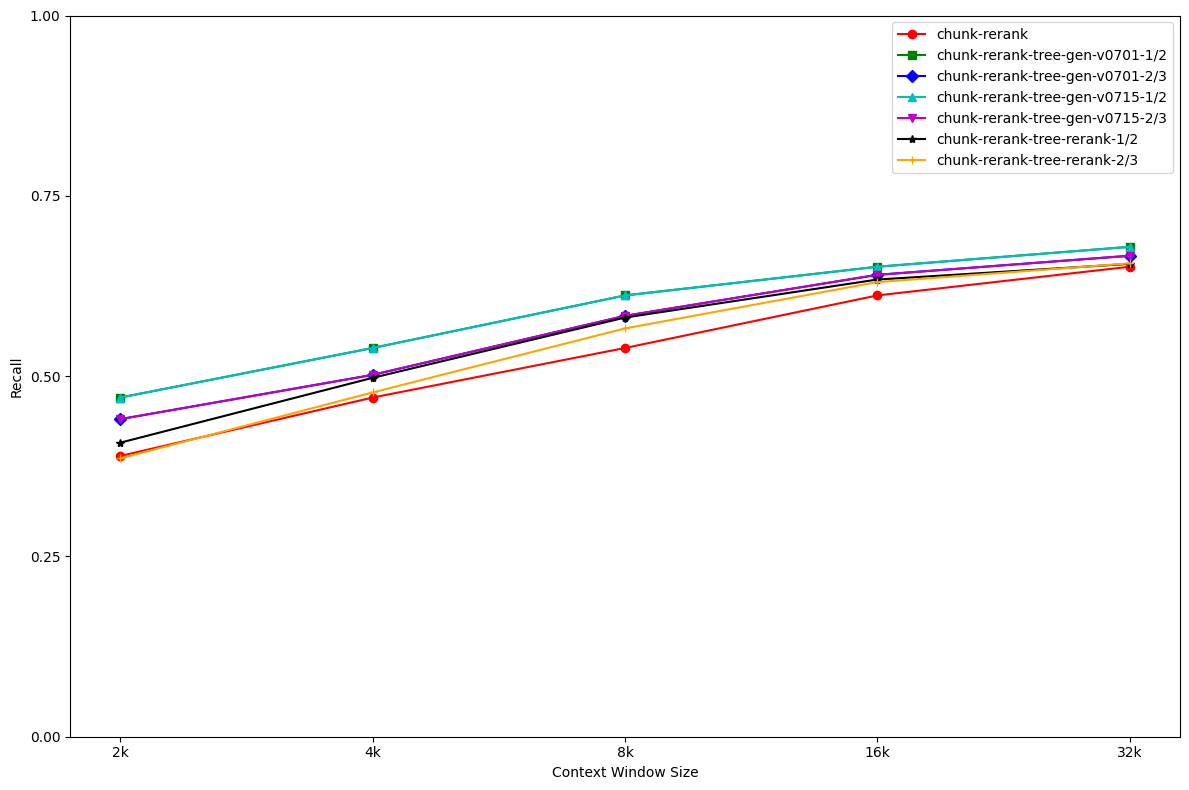

In [82]:
print(context_answer_recalls)

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 8))
plt.subplots_adjust(hspace=0)

#  x axis is the context window size
context_windows = ["2k", "4k", "8k", "16k", "32k"]
x_ticks=np.linspace(0, 5, 5)
#  y axis is the recall
y_ticks=np.linspace(0, 1, 5)
colors=["r", "g", "b", "c", "m", "y", "k", "w", "orange", "purple", "brown", "pink"]
markers=["o", "s", "D", "^", "v", "p", "*", "x", "+", "1", "2", "3"]
#  context window recall
reference_format="chunk-rerank"
y_values = list(context_answer_recalls[:len(context_windows)])
ax.plot(x_ticks, y_values, label=reference_format, color=colors[0], marker=markers[0])
reference_format="chunk-rerank-tree-gen"
for vidx in range(len(versions)):
    for fidx in range(2):
        version_idx=1+versions.index(version) * 2 + fidx
        y_values = list(context_answer_recalls[len(context_windows)*version_idx:len(context_windows)*(version_idx+1)])
        ax.plot(x_ticks, y_values, label=f"{reference_format}-{versions[vidx]}-{['1/2', '2/3'][fidx]}", color=colors[vidx*2+fidx+1], marker=markers[vidx*2+fidx+1])
reference_format="chunk-rerank-tree-rerank"
for fidx in range(2):
    version_idx=5+ fidx
    y_values = list(context_answer_recalls[len(context_windows)*version_idx:len(context_windows)*(version_idx+1)])
    ax.plot(x_ticks, y_values, label=f"{reference_format}-{['1/2', '2/3'][fidx]}", color=colors[2*fidx+6], marker=markers[2*fidx+6])

ax.set_xticks(x_ticks)
ax.set_xticklabels(context_windows)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"{y:.2f}" for y in y_ticks])
ax.set_xlabel("Context Window Size")
ax.set_ylabel("Recall")
ax.legend()
# plt.show()
plt.tight_layout()
plt.savefig(f"../figures/{dataset}_answer_recall.png", format="png")
# plt.close()

In [39]:
#  analyze recall with different depths on 64k context window
from tqdm import tqdm
import numpy as np

print(f"version: {version}")
rerank_model="bgelargeen"

import multiprocessing

processes=[]
depths=[i for i in range(1, 13)]
versions=["v0701", "v0715"]
depth_recalls=multiprocessing.Manager().list([0.0]*(len(depths)*len(versions)))
depth_nums=multiprocessing.Manager().list([0]*(len(depths)*len(versions)))
kept_depth_nums=multiprocessing.Manager().list([0]*(len(depths)*len(versions)))

def calculate_depth_recall(version):
    context_window="64k"
    reference_format="treegen"
    if reference_format in ["html-trim"]:
        ref_file = f"../html_data/{dataset}/{search_engine}/{reference_format}/{search_engine}html-{rewrite_method}-{rerank_model}-{dataset}-{split}-{context_window}.jsonl"
    elif reference_format in ["treegen"]:
        ref_file = f"../html_data/{dataset}/treegen/{version}/{search_engine}html-{rewrite_method}-{version}-{dataset}-{split}-{context_window}.jsonl"
    else:
        raise NotImplementedError("reference_format not found")
    print(f"ref_file: {ref_file}")
    ref_lines = [json.loads(line) for line in open(ref_file, "r")]
    
    if "answers" in ref_lines[0]:
        answers = [ref_line['answers'] for ref_line in ref_lines]
    elif "short_answers" in ref_lines[0]:
        answers = [ref_line['short_answers'] for ref_line in ref_lines]
    elif "answer" in ref_lines[0]:
        answers = [ref_line['answer'] for ref_line in ref_lines]
    else:
        raise NotImplementedError("answers not found in ref_lines")
    length_matched_paths=[[] for _ in range(len(depths))]
    kept_length_matched_paths=[[] for _ in range(len(depths))]
    for idx in tqdm(range(len(ref_lines)), desc=f"{version}: {context_window}"):
        html=ref_lines[idx]["html"]
        if reference_format in ["html-trim", "treegen"]:
            html_trim=ref_lines[idx]["html_trim"]
        elif reference_format in ["fill-chunk"]:
            html_trim=ref_lines[idx]["fill-chunk"]
        else:
            raise NotImplementedError("reference_format not found")
        answer=answers[idx]
        
        #  split the html into subtrees
        soup = bs4.BeautifulSoup(html, 'html.parser')
        html_chunk_paths = split_tree(soup)
        matched_paths = []
        
        for path in html_chunk_paths:
            if calculate_short_answer_EM(str(path[0]), answer)["exact_match"] > 0.0:
                matched_paths.append(path)
                
        if len(matched_paths) == 0:
            continue
        else:
            #  visit soup trim through matched paths
            soup_trim = bs4.BeautifulSoup(html_trim, 'html.parser')
            for matched_path in matched_paths:
                path = matched_path[1]
                depth = min(12, len(path))
                length_matched_paths[depth-1].append(matched_path)
                tag = soup_trim
                for p in path:
                    for child in tag.contents:
                        if isinstance(child, bs4.element.Tag):
                            if child.name == p:
                                tag = child
                                break
                #  check if trace to the end of the path
                if tag.name == path[-1]:
                    kept_length_matched_paths[depth-1].append(matched_path)
                    # print(f"matched path: {path}")
    version_idx=versions.index(version)
    for d in range(len(depths)):
        if len(length_matched_paths[d]) == 0:
            depth_recalls[d+version_idx*len(depths)]=0.0
            depth_nums[d+version_idx*len(depths)]=0
            kept_depth_nums[d+version_idx*len(depths)]=0
        else:
            depth_recalls[d+version_idx*len(depths)]=len(kept_length_matched_paths[d])/len(length_matched_paths[d])
            depth_nums[d+version_idx*len(depths)]=len(length_matched_paths[d])
            kept_depth_nums[d+version_idx*len(depths)]=len(kept_length_matched_paths[d])
    print(f"version: {version}, depth_recalls: {depth_recalls[version_idx*len(depths):(version_idx+1)*len(depths)]}")
    
    
for version in versions:
    p=multiprocessing.Process(target=calculate_depth_recall, args=(version,))
    p.start()
    processes.append(p)
    
for p in processes:
    p.join()

version: v0715
ref_file: ../html_data/asqa/treegen/v0701/binghtml-slimplmqr-v0701-asqa-test-64k.jsonl
ref_file: ../html_data/asqa/treegen/v0715/binghtml-slimplmqr-v0715-asqa-test-64k.jsonl


v0701: 64k: 100%|██████████| 400/400 [05:38<00:00,  1.18it/s]


version: v0701, depth_recalls: [0.9902439024390244, 0.9686411149825784, 0.7028508771929824, 0.45970603142422706, 0.41439946914399467, 0.454283177984909, 0.2683302958082153, 0.23200166458593424, 0.20687418936446172, 0.16323529411764706, 0.1012396694214876, 0.09601449275362318]


v0715: 64k: 100%|██████████| 400/400 [05:39<00:00,  1.18it/s]


version: v0715, depth_recalls: [0.9902439024390244, 0.9976771196283392, 0.7653508771929824, 0.501773948302078, 0.4389515593895156, 0.440745672436751, 0.27015281087901305, 0.24282147315855182, 0.24319066147859922, 0.12867647058823528, 0.09090909090909091, 0.1105072463768116]


In [40]:
print(depth_recalls)
print(depth_nums)
print(kept_depth_nums)
# [1.0, 0.9838709677419355, 0.6756756756756757, 0.4977168949771689, 0.3355263157894737, 0.24550898203592814, 0.30948419301164726, 0.18529411764705883, 0.1497326203208556, 0.07017543859649122, 0.075, 0.1702127659574468, 1.0, 0.967741935483871, 0.6959459459459459, 0.5159817351598174, 0.2993421052631579, 0.26047904191616766, 0.2795341098169717, 0.22058823529411764, 0.19786096256684493, 0.08333333333333333, 0.075, 0.06382978723404255]
# [51, 62, 148, 219, 304, 334, 601, 340, 187, 228, 40, 94, 51, 62, 148, 219, 304, 334, 601, 340, 187, 228, 40, 94]
# [51, 61, 100, 109, 102, 82, 186, 63, 28, 16, 3, 16, 51, 60, 103, 113, 91, 87, 168, 75, 37, 19, 3, 6]

[0.9902439024390244, 0.9686411149825784, 0.7028508771929824, 0.45970603142422706, 0.41439946914399467, 0.454283177984909, 0.2683302958082153, 0.23200166458593424, 0.20687418936446172, 0.16323529411764706, 0.1012396694214876, 0.09601449275362318, 0.9902439024390244, 0.9976771196283392, 0.7653508771929824, 0.501773948302078, 0.4389515593895156, 0.440745672436751, 0.27015281087901305, 0.24282147315855182, 0.24319066147859922, 0.12867647058823528, 0.09090909090909091, 0.1105072463768116]
[410, 861, 912, 1973, 3014, 4506, 7133, 4806, 3084, 1360, 484, 552, 410, 861, 912, 1973, 3014, 4506, 7133, 4806, 3084, 1360, 484, 552]
[406, 834, 641, 907, 1249, 2047, 1914, 1115, 638, 222, 49, 53, 406, 859, 698, 990, 1323, 1986, 1927, 1167, 750, 175, 44, 61]


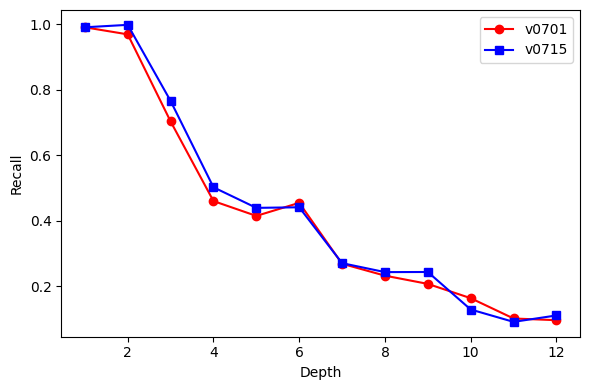

In [41]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
x = [i for i in range(1, 13)]
x_value = [i for i in range(1, 13)]
x_label = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]
ax1.plot(x, depth_recalls[:12], label="v0701", color="r", marker="o")
ax1.plot(x, depth_recalls[12:], label="v0715", color="b", marker="s")
ax1.set_ylabel("Recall")
ax1.set_xlabel("Depth")
ax1.legend()

plt.tight_layout()
plt.savefig(f"../figures/{dataset}_depth_recall.png", format="png")

In [ ]:
#  draw the curve for depth recall, and bar for the number of matched paths and kept matched paths
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
x = [i for i in range(1, 13)]
x_value = [i for i in range(1, 13)]
x_label = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"]
ax1.plot(x, depth_recalls, label="v0701", color="r", marker="o")
ax1.set_ylabel("Recall")
ax1.set_xlabel("Depth")
ax1.legend()

ax2 = ax1.twinx()
ax2.bar(x, depth_nums, label="matched paths", color="b", alpha=0.8)

In [198]:
ridx=0
print(ref_lines[ridx].keys())
# dict_keys(['qa_pairs', 'wikipages', 'annotations', 'id', 'question', 'answer', 'short_answers', 'long_answers', 'slimplmqr_rewrite', 'slimplmqr_results', 'page_contents', 'metadatas', 'html_trim'])
print(ref_lines[ridx]["page_contents"][0], ref_lines[ridx]["metadatas"][0])
print(ref_lines[ridx]["page_contents"][1], ref_lines[ridx]["metadatas"][1])
print(ref_lines[ridx]["page_contents"][2], ref_lines[ridx]["metadatas"][2])
print(ref_lines[ridx]["page_contents"][-1], ref_lines[ridx]["metadatas"][-1])

dict_keys(['id', 'paragraphs', 'question_decomposition', 'answer', 'answer_aliases', 'answerable', 'question', 'slimplmqr_rewrite', 'slimplmqr_results', 'page_contents', 'metadatas', 'html_trim'])
sport.wikisort.org - Stadium 
 Search  /  Calendar 
 
 Ciudad Deportiva  was Real Madrid's former training complex located on the Paseo de la Castellana in  Madrid , Spain. 
 Former sports venue in Spain 
 This article  does not cite any sources .   ( June 2019 ) {'Header 1': '#TITLE#', 'html_index': 3, 'chunk_index': 16}
ciudad   deportiva   noun, feminine — {'Header 2': 'ciudad deportiva noun,\xa0feminine—', 'html_index': 2, 'chunk_index': 9}
Controversy 
 By the end of the 20th century the land surrounding the Ciudad Deportiva was no longer on the outskirts of Madrid, but had become a transportation hub with the north of the city and a financial area. Its location along the Castellana further increased the land's value. With Real Madrid's debts mounting in the late 1990s, plans to re-zone 

In [204]:
soup=bs4.BeautifulSoup(ref_lines[ridx]["html_trim"][3], 'html.parser')
for h in soup.find_all(["h1", "h2", "h3", "h4"]):
    # print(h.get_text())
    if h.get_text().strip() == "Controversy":
        print(h)

Real Madrid
Controversy
<h4>Controversy</h4>
Ciudad del Madrid


In [203]:
soup.body.get_text().split()[0]

'sport.wikisort.org'

In [153]:
print(len(ref_lines[ridx]["html_trim"]))
print(len(ref_lines[ridx]["slimplmqr_results"]))

35
35


In [34]:
#  repair the html index
split = "test"
rewrite_method = "slimplmqr"
version="v0715"
search_engine="bing"
chat_tokenizer="llama"

def repair_html_index(dataset, context_window):
    reference_format="html-trim"
    ref_file = f"../html_data/{dataset}/{search_engine}/{reference_format}/{chat_tokenizer}/{search_engine}html-{rewrite_method}-{rerank_model}-{dataset}-{split}-{context_window}.jsonl"
    # print(f"ref_file: {ref_file}")
    ref_lines = [json.loads(line) for line in open(ref_file, "r")]
    #  repair html index
    for idx, data_line in tqdm(enumerate(ref_lines), total=len(ref_lines), desc=f"{dataset}-{context_window}"):
        docs = []
        html = [clean_xml(d['html']) for d in ref_lines[idx][f'{rewrite_method}_results']]
        html = [h for h in html if h.strip()]
        assert len(html) == len(ref_lines[idx][f'html_trim']) or len(ref_lines[idx][f'html_trim']) == 1
        html_indexes = []
        for idh, h in enumerate(html):
            splits = html_splitter.split_text(h)
            html_indexes.extend([idh] * len(splits))
            docs.extend(splits)
            
        #  sort the docs by chunk index
        metadatas=data_line["metadatas"]
        metadatas = sorted(metadatas, key=lambda x: (x["chunk_index"]))
        assert len(docs) == len(metadatas)
        for idx in range(len(docs)):
            metadatas[idx]["html_index"]=html_indexes[idx]
            
    #  save the repaired html index
    with open(ref_file, "w") as f:
        for line in ref_lines:
            f.write(json.dumps(line, ensure_ascii=False) + "\n")
            
import multiprocessing
processes=[]
context_windows=["2k", "4k", "8k", "16k", "32k", "64k"]
datasets=["asqa", "nq", "hotpot-qa", "trivia-qa", "musique"]
for dataset in datasets:
    for context_window in context_windows:
        p=multiprocessing.Process(target=repair_html_index, args=(dataset, context_window))
        p.start()
        processes.append(p)
        
for p in processes:
    p.join()
print("done")

musique-2k: 100%|██████████| 400/400 [09:34<00:00,  1.44s/it]


done


In [35]:
from transformers import AutoModel
from transformers import AutoTokenizer

# model=AutoModel.from_pretrained("../../../huggingface/Meta-Llama-3.1-70B-Instruct", trust_remote_code=True)
tokenizer=AutoTokenizer.from_pretrained("../../../huggingface/Meta-Llama-3.1-70B-Instruct",trust_remote_code=True)

In [34]:
import requests
from requests.adapters import HTTPAdapter
from urllib3 import Retry

# <|begin_of_text|><|start_header_id|>system<|end_header_id|>
# 
# Environment: ipython
# Tools: brave_search, wolfram_alpha
# 
# Cutting Knowledge Date: December 2023
# Today Date: 23 Jul 2024
# 
# You are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>
# 
# Can you help me solve this equation: x^3 - 4x^2 + 6x - 24 = 0<|eot_id|><|start_header_id|>assistant<|end_header_id|>

def vllm_api_call(url, prompt, repetition_penalty=-1, temperature=-1, top_k=-1, top_p=-1,
                  max_new_tokens=-1, do_sample=True, seed=None):
    retry_strategy = Retry(
        total=1,  # 最大重试次数（包括首次请求）
        backoff_factor=1,  # 重试之间的等待时间因子
        status_forcelist=[429, 500, 502, 503, 504],  # 需要重试的状态码列表
        allowed_methods=["POST"]  # 只对POST请求进行重试
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    # 创建会话并添加重试逻辑
    session = requests.Session()
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    request_data = {
        'prompt': prompt,
        "repetition_penalty": repetition_penalty,
        "temperature": temperature,
        "max_tokens": max_new_tokens,
    }
    if seed != None:
        request_data['seed'] = seed
    if top_p != -1 and top_p != None:
        request_data["top_p"] = top_p
    if top_k != -1 and top_k != None:
        request_data["top_k"] = top_k
    response = session.post(url, json=request_data)
    data = json.loads(response.text)
    ans = data["text"][0][len(prompt):].strip()
    return ans

pre_text = "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nYou are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n"
post_text = "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"
vllm_api_call("http://172.16.0.17:8000/generate", f"{pre_text}What is the capital of France?{post_text}", repetition_penalty=1.05, temperature=0.3, top_k=5, top_p=0.85,
                                 max_new_tokens=1024, do_sample=True, seed=3)

'The capital of France is Paris.'

In [9]:
file_name="../html_data/asqa/llama70b32k/bing/llama70b32k-html-trim-slimplmqr-bgelargeen-asqa-test.jsonl"
import json
lines = [json.loads(line) for line in open(file_name, "r")]

In [11]:
idx=118
print(lines[idx].keys())
# dict_keys(['id', 'output', 'question', 'answer', 'slimplmqr_rewrite', 'slimplmqr_results', 'page_contents', 'metadatas', 'html_trim', 'llama70b8k_html-trim'])
print(lines[idx]["llama70b32k_html-trim"])


dict_keys(['qa_pairs', 'wikipages', 'annotations', 'id', 'question', 'answer', 'short_answers', 'long_answers', 'slimplmqr_rewrite', 'slimplmqr_results', 'page_contents', 'metadatas', 'html_trim', 'llama70b32k_html-trim'])
According to the provided HTML content, the character of Alan Turner's son, Terence Turner, was not explicitly mentioned to be played by a specific actor. However, it is mentioned that Terence was introduced in 1985 and returned to the village in 2006.
